# Final Exam - Open (Solutions)

## FINM 36700 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Points
* The exam is `85` points.
* You have `85` minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.


Submission
* You will upload your solution to the `Final - Open` assignment on Canvas, where you downloaded this. 
* Be sure to **submit** on Canvas, not just **save** on Canvas.
* Your submission should be readable, (the graders can understand your answers.)
* Your submission should **include all code used in your analysis in a file format that the code can be executed.** 

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo - you are welcome to use the code posted there without citation.

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

- For Section 1:
    * `data/final_exam_data.xlsx`
- for Section 2:
    * `data/fx_rf_data.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 40     |
| 2       | 45     |

### Each numbered question is worth 5 points unless otherwise specified.

***

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import sys

import warnings
warnings.filterwarnings("ignore")

In [44]:
# Section 1
asset_rets = pd.read_excel('../data/final_exam_data.xlsx', sheet_name='Asset Returns', index_col=0)
fac_rets = pd.read_excel('../data/final_exam_data.xlsx', sheet_name='Factor Returns', index_col=0)['factor']
asset_betas = pd.read_excel('../data/final_exam_data.xlsx', sheet_name='Asset Betas', index_col=0)['betas']

# Section 2
fx_rates = pd.read_excel('../data/fx_rf_data.xlsx', sheet_name='exchange rates', index_col=0)
rf_rates = pd.read_excel('../data/fx_rf_data.xlsx', sheet_name='risk-free rates', index_col=0) / 252

# Create function to retrieve common statistics
def stats_mean_vol_sharpe(data,portfolio = None,portfolio_name = 'Portfolio',annualize = 12):
    
    if portfolio is None:
        returns = data
    else:
        returns = data @ portfolio
    
    output = returns.agg(['mean','std'])
    output.loc['sharpe'] = output.loc['mean'] / output.loc['std']
    
    output.loc['mean'] *= annualize
    output.loc['std'] *= np.sqrt(annualize)
    output.loc['sharpe'] *= np.sqrt(annualize)
    
    if portfolio is None:
        pass
    else:
        output.columns = [portfolio_name]
    
    return output

# Create function to retrieve tail risk statistics
# Note this uses a simple historic definition of VaR and CVaR
def stats_tail_risk(data, portfolio = None, portfolio_name = 'Portfolio', VaR = 0.05):
    
    if portfolio is None:
        returns = data
    else:
        returns = data @ portfolio
    
    output = returns.agg(['skew',
                          'kurt'])
    output.loc['VaR'] = returns.quantile(q = 0.05)
    output.loc['CVaR'] = returns[returns <= output.loc['VaR']].mean()
    output = pd.concat([output, max_drawdown(returns,portfolio,portfolio_name)])
    ### ^^^ THIS STEP ONLY NECESSARY IF LOOKING FOR MAX DRAWDOWN AS WELL
    if portfolio is None:
        pass
    else:
        output.columns = portfolio_name
    
    return output


# Create function to calculate max drawdown and associated dates
def max_drawdown(data, portfolio = None, portfolio_name = 'Portfolio'):
    
    if portfolio is None:
        returns = data
        output = pd.DataFrame(columns=returns.columns)
    else:
        returns = data @ portfolio
        output = pd.DataFrame(columns=[portfolio_name])
    
    cumulative = (returns + 1).cumprod()
    maximum = cumulative.expanding().max()
    drawdown = cumulative / maximum - 1
    
    for col in output.columns:
        
        output.loc['MDD',col] = drawdown[col].min()
        
    return output

# 1. Cross-Sectional Factor Pricing

Use the data found in the file `final_data.xlsx`. The sheet named `Asset Returns` contains daily excess returns data for various assets; the sheet named `Factor Returns` contains daily excess returns data for some unknown factor; and the sheet named `Asset Betas` contains the betas of each asset with respect to the given factor.

Consider the data to have an annualization factor of `252` days per year.

### 1.
(10pts)

Using linear regression, estimate the factor risk premium for __each point in time__, using the following model: $\phantom{Brian Hood}$ 

$$
\tilde{r}^{(i)}_t = \beta^{(i)}\lambda_t + \epsilon^{(i)}_t
$$

Using your estimated series $\lambda_t$, report...

* the last 3 values. 

* the annualized mean.

* the annualized vol.

<span style="color:blue">__Solution:__</span>

In [45]:
dates = asset_rets.index

fitted_premia = []

for t in dates:
    
    ols_fit_premium_t = sm.OLS(asset_rets.loc[t], asset_betas).fit().params['betas']
    fitted_premia.append(ols_fit_premium_t)
    
fitted_premia = pd.Series(index=dates, data=fitted_premia)

<span style="color:blue">Last 3 values:</span>

In [46]:
fitted_premia.tail(3)

Date
2024-11-06   0.0230
2024-11-07   0.0011
2024-11-08   0.0018
dtype: float64

<span style="color:blue">Annualized mean:</span>

In [47]:
fitted_premia.mean() * 252

np.float64(0.1754874142533425)

<span style="color:blue">Annualized vol:</span>

In [48]:
fitted_premia.std() * np.sqrt(252)

np.float64(0.11688953313031768)

### 2.

(10pts)

Compare $\lambda_t$ to the realized factor returns, $\tilde{f}_t$.

* Plot the cumulative (excess) returns of $\lambda_t$ and $\tilde{f}_t$.
* Report the correlation between these two series.
* Report the serial correlation of each series.

Should we expect the serial correlation of $\tilde{f}$ to be near zero? What about $\lambda_t$?

<span style="color:blue">__Solution:__</span>

In [49]:
fac_premia = pd.concat([fac_rets, fitted_premia], axis=1, keys=['Actual', 'Fitted'])

<span style="color:blue">Plot cumulative (excess) returns:</span>

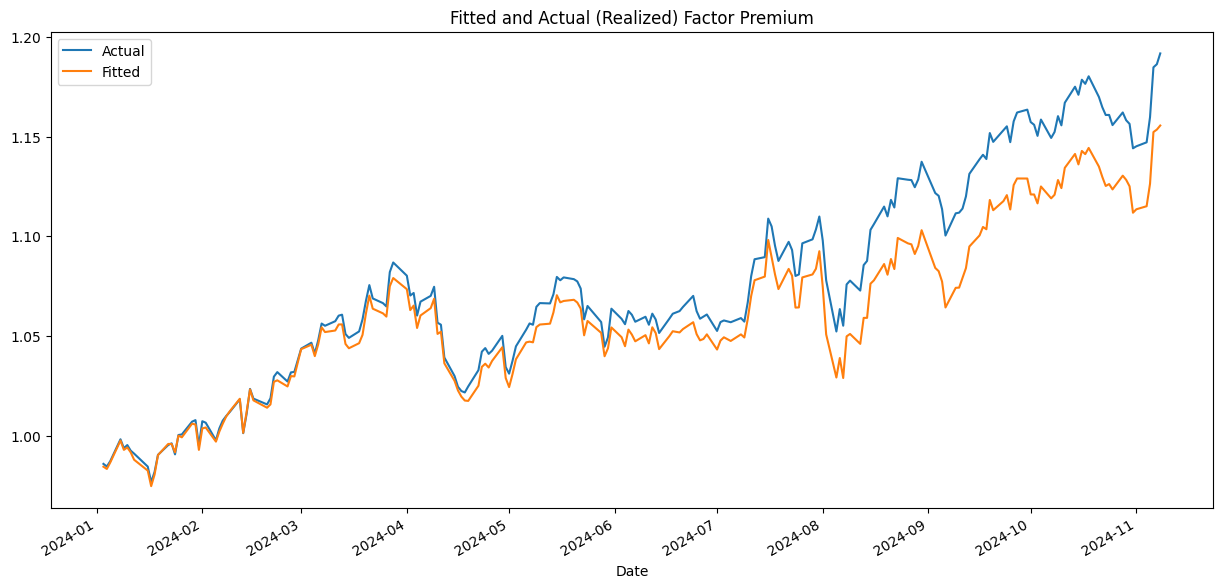

In [50]:
(1 + fac_premia).cumprod().plot(figsize=(15, 7), title='Fitted and Actual (Realized) Factor Premium'); plt.show()

<span style="color:blue">Report correlation:</span>

In [51]:
fac_premia.corr()

,Actual,Fitted
Actual,1.0000,0.9851
Fitted,0.9851,1.0000


<span style="color:blue">Report serial correlation:</span>

In [52]:
fac_premia.corrwith(fac_premia.shift())

Actual   0.0184
Fitted   0.0016
dtype: float64

<span style="color:blue">Should we expect the serial correlation of $\tilde{f}$ to be near zero? What about $\lambda_t$?</span>

The serial correlation of $\tilde{f}$ is likely to be near zero which is a common characteristic among tradable risky assets. The standard belief is that there are few fundamental reasons for properly priced assets to have serial correlation, and in a frictionless market serial correlation might present an attractive opportunity.

This is not always the case, as market frictions and investor risk preferences can lead to small serial correlation. It is important to note that a strategy meant to "exploit" autocorrelation still has risk.

$\lambda_t$ is slightly different in that it is our estimate of the *risk premium* to the factor. Note that this is not the same as the realized return of the factor. This may have more autocorrelation due to the nature of how risk premia evolve over time along with persistent shifts in economic variables, investor risk preferences, etc.

### 3.

We estimated our factor premium in a regression that excluded an intercept term. Why might we have done this? In what circumstance would we prefer to include an intercept term?

<span style="color:blue">__Solution:__</span>

There are multiple reasons behind whether or not we should include an intercept, some of which are more general and some of which are more directly applicable to this problem.

__When to exclude intercept:__
- We believe that our factor model holds true, then from a theoretical standpoint we believe $\alpha_t=0$ and thus we should not fit this parameter in our regression.
- From a statistical perspective, we trust our estimate of the mean return of the assets.
- We care about measuring the *level* of asset returns with respect to the risk-premium, not the deviations from their means.

__When to include an intercept:__
- We would like to assess whether our factor model holds true.
- We may not trust our estimate of the mean return of the assets.
- We care about measuring the deviations from their means.

__Note:__ Take a look at the plot below, with includes the cumulative returns of the fitted premia when done so with and without an intercept. When using an intercept, we clearly fail to replicate the level of returns found present in the actual (realized) returns.

In [53]:
fitted_premia_intercept = []

for t in dates:
    
    ols_fit_premium_t_intercept = sm.OLS(asset_rets.loc[t], sm.add_constant(asset_betas)).fit().params['betas']
    fitted_premia_intercept.append(ols_fit_premium_t_intercept)
    
fitted_premia_intercept = pd.Series(index=dates, data=fitted_premia_intercept)

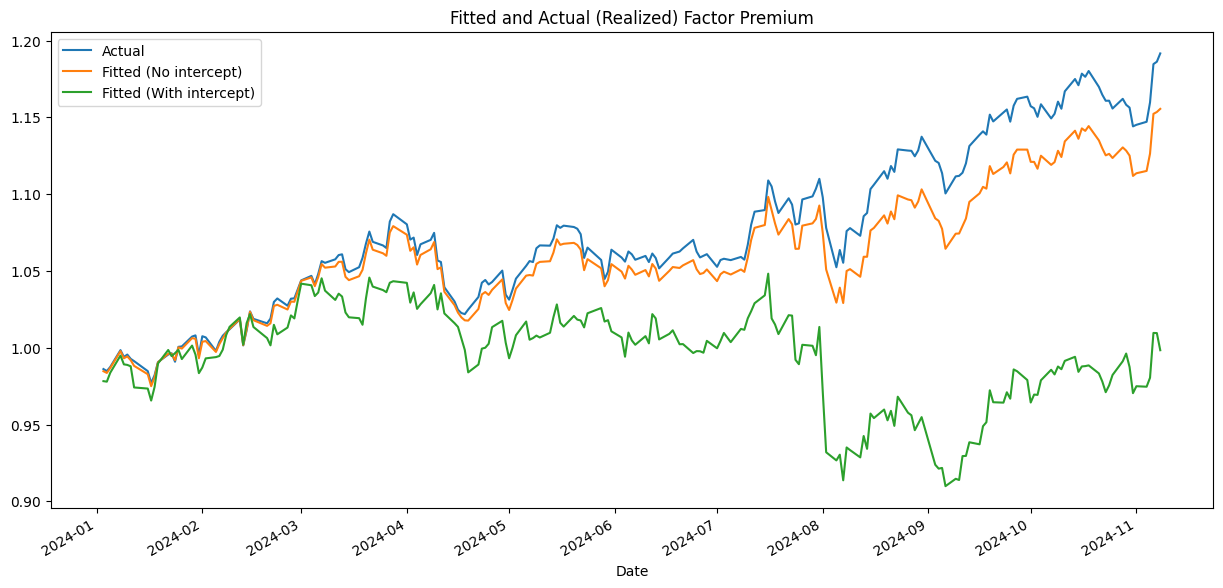

In [54]:
_ = pd.concat([fac_rets, fitted_premia, fitted_premia_intercept], axis=1,
              keys=['Actual', 'Fitted (No intercept)', 'Fitted (With intercept)'])
(1 + _).cumprod().plot(figsize=(15, 7), title='Fitted and Actual (Realized) Factor Premium'); plt.show()

### 4.

(10pts)

Now, use the actual factor returns, $\tilde{f}_t$to analyze the fit of this pricing model using a __single__ cross-sectional regression to estimate  $\phantom{Brian Hood}$

$$
E[r^{(i)}] = \eta + \beta^{(i)} E[\tilde{f}] + \epsilon^{(i)}
$$

How well does this factor work for pricing? Provide supporting evidence for your answer.

<span style="color:blue">__Solution:__</span>

In [55]:
y = asset_rets.mean()
x = asset_betas

model_cs_means = sm.OLS(y, sm.add_constant(x)).fit()

model_cs_means.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1534
Date:                Thu, 19 Dec 2024   Prob (F-statistic):              0.695
Time:                        02:31:53   Log-Likelihood:                 2657.1
No. Observations:                 498   AIC:                            -5310.
Df Residuals:                     496   BIC:                            -5302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      6.409      0.000       0.001       0.001
betas       4.399e-05      0.000      0.392      0.695      -0.000       0.000
==============================================================================
Omnibus:                       44.670   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.181
Skew:                          -0.147   Prob(JB):                     1.88e-47
Kurtosis:                       6.207   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
model_cs_means.rsquared

np.float64(0.00030916453633456076)

In [57]:
model_cs_means.params['const']

np.float64(0.0007940771564678901)

In [58]:
model_cs_means.params['const'] * 252

np.float64(0.2001074434299083)

<span style="color:blue">How well does this factor work for pricing?</span>

Pointing to the low $R^2$ and the large (annualized) intercept term of nearly 20%, we can conclude this factor works poorly in this pricing model. However, given our small sample size that likely only spans a single regime (2024 bull market), it is possible that we find better results with other data.

### 5.

The factor we've used, $\tilde{f}$ is actually the **equally**-weighted portfolio of equities. Suppose the CAPM holds exactly, with the **value**-weighted market equity portfolio. In that case, what would we expect, theoretically, from the previous section?

<span style="color:blue">__Solution:__</span>

Because our the equally weighted portfolio is similar (correlated) to the market portfolio, we would find that the equally weighted portfolio would indeed have some pricing power (statistically significant premium and large $R^2$). We would not, however, have the perfect fit that the market portfolio would have. Instead, we would find our $R^2$ to be high but less than one, and our intercept to be non-zero.

***

# 2. Currency Trades

For this question, use the data set from `data/fx_rf_data.xlsx`.

Calculate the **arithmetic** (not log) excess return to holding each foreign currency.

Data Note:
* Consider the risk-free rate data as being quoted as an annualized value, where this annualization is a scaling of `252`.

Throughout this problem, we only consider returns generated between `Jan 2018` and `Aug 2024`.

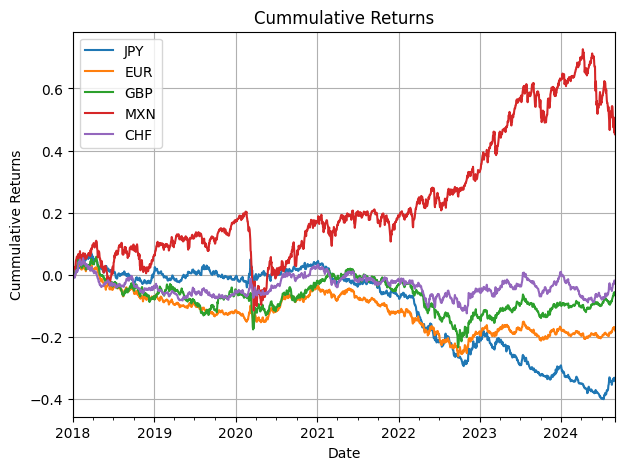

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import sys
sys.path.append(os.path.abspath('..'))

import cmds.portfolio_management_helper as pmh

ANNUALIZATION_FACTOR = 252

fx_rates = pmh.read_excel_default('../data/fx_rf_data.xlsx', sheet_name='exchange rates')
rf_rates = pmh.read_excel_default('../data/fx_rf_data.xlsx', sheet_name='risk-free rates')

rf_rates = rf_rates / ANNUALIZATION_FACTOR

fx_rates_filtered = fx_rates.loc["2018-01-01":"2024-08-31"]
rf_rates_filtered = rf_rates.loc["2018-01-01":"2024-08-31"]
fx_excess_returns = (
    (fx_rates_filtered / fx_rates_filtered.shift() * (1 + rf_rates_filtered.drop('USD', axis=1)))
    .apply(lambda x: x / (1 + rf_rates_filtered['USD']))
    - 1
)

# The following provides very similar results (it allows for a simplificatin of the formula)
fx_excess_returns_alternative = (
    (fx_rates_filtered / fx_rates_filtered.shift() - 1)
    + ((rf_rates_filtered.drop('USD', axis=1).apply(lambda x: x - rf_rates_filtered['USD'])))
)

pmh.calc_cummulative_returns(fx_excess_returns)

### 1.

Report the first and final three values of each of these excess return series.

<span style="color:blue">__Solution:__</span>

In [60]:
fx_tot_rets = fx_rates / fx_rates.shift() * (1 + rf_rates.drop('USD', axis=1)) - 1
fx_retsx = fx_tot_rets.subtract(rf_rates['USD'], axis=0)

<span style="color:blue">First three:</span>

In [61]:
fx_retsx.head(3)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,NaN,NaN,NaN,NaN,NaN
2008-01-02,0.0179,0.0084,-0.0028,-0.0022,0.0123
2008-01-03,0.0030,0.0024,-0.0049,0.0029,0.0076


<span style="color:blue">Last three:</span>

In [62]:
fx_retsx.tail(3)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2024-10-29,-0.0006,0.0006,0.0033,-0.0008,-0.0023
2024-10-30,-0.0006,0.0034,-0.0041,-0.0042,0.0005
2024-10-31,0.0090,0.0025,-0.0049,0.0061,0.0029


<span style="color:blue">If only looking at 2018-2024:</span>

In [63]:
fx_retsx.loc['2018-01':'2024-08'].head(3)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2018-01-01,0.0002,0.0005,-0.0008,0.0010,-0.0005
2018-01-02,0.0033,0.0038,0.0064,0.0061,0.0032
2018-01-03,-0.0021,-0.0037,-0.0055,0.0098,-0.0054


In [64]:
fx_retsx.loc['2018-01':'2024-08'].tail(3)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2024-08-28,-0.0045,-0.0058,-0.0053,0.0061,-0.0008
2024-08-29,-0.0030,-0.0039,-0.0018,-0.0102,-0.0062
2024-08-30,-0.0083,-0.0027,-0.0031,0.0064,-0.0028


<span style="color:blue">This is also acceptable (same values, but shifted):</span>

In [65]:
# Acceptable
_ = fx_rates.shift(-1) / fx_rates * (1 + rf_rates.drop('USD', axis=1)) - 1
_.subtract(rf_rates['USD'], axis=0)

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,0.0179,0.0084,-0.0028,-0.0022,0.0123
2008-01-02,0.0030,0.0024,-0.0049,0.0029,0.0076
2008-01-03,0.0065,-0.0005,0.0016,-0.0035,0.0021
2008-01-04,-0.0056,-0.0032,-0.0018,0.0025,-0.0073
2008-01-07,0.0025,0.0007,0.0015,-0.0026,0.0035
...,...,...,...,...,...
2024-10-25,-0.0064,0.0014,0.0008,-0.0026,0.0015
2024-10-28,-0.0006,0.0006,0.0033,-0.0008,-0.0023
2024-10-29,-0.0006,0.0034,-0.0041,-0.0042,0.0005


### 2.

Report the following performance metrics. Annualize the mean and volatility using an assumption of `252` days per year.

* mean
* volatility
* skewness
* (excess) kurtosis
* max drawdown

Also report the correlation matrix.

In [66]:
pmh.calc_summary_statistics(
    fx_excess_returns,
    annual_factor=ANNUALIZATION_FACTOR,
    provided_excess_returns=True,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Kurtosis', 'Drawdown']
)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Excess Kurtosis,Max Drawdown
JPY,-0.0568,0.0847,-0.6705,6.5262,-0.4398
EUR,-0.0261,0.0706,-0.3691,1.4853,-0.2895
GBP,-0.0057,0.0891,-0.0639,3.8644,-0.2755
MXN,0.0629,0.1251,0.5025,2.9871,-0.2645
CHF,-0.0015,0.0716,-0.0204,2.3595,-0.1685


In [67]:
pmh.calc_correlations(fx_excess_returns, print_highest_lowest=False, return_heatmap=False)

,JPY,EUR,GBP,MXN,CHF
JPY,1.0000,0.4393,0.3719,0.0768,0.5511
EUR,0.4393,1.0000,0.6892,0.3332,0.7520
GBP,0.3719,0.6892,1.0000,0.3600,0.5524
MXN,0.0768,0.3332,0.3600,1.0000,0.1921
CHF,0.5511,0.7520,0.5524,0.1921,1.0000


In [68]:
fx_retsx.corr()

,JPY,EUR,GBP,MXN,CHF
JPY,1.0000,0.2744,0.1504,-0.0831,0.3818
EUR,0.2744,1.0000,0.6129,0.3521,0.6355
GBP,0.1504,0.6129,1.0000,0.3675,0.3962
MXN,-0.0831,0.3521,0.3675,1.0000,0.1483
CHF,0.3818,0.6355,0.3962,0.1483,1.0000


<span style="color:blue">If only looking at 2018-2024:</span>

### 3.

As of `Dec 2017`, which of these currency trades has the most **carry**? 

Does this indicate high or low returns, assuming UIP?

<span style="color:blue">

In this context, carry refers to the risk-free rate of the foreign currency in excess of the risk-free rate of the funding currency (USD). Whether we look at just the last date of `Dec 2017` or some combination of dates, we find that `MXN` has the highest carry.

Assuming UIP, this does not indicate high nor low returns, as UIP asserts that any gains (or losses) stemming from  foreign risk-free rates will be offset by depreciation (or appreciation) in the foreign currency. In other words, UIP says that we can expect zero excess returns from holding the foreign currency (the carry strategy).

</span>

In [69]:
rf_rates.subtract(rf_rates['USD'], axis=0).loc['2017-12-29'] * ANNUALIZATION_FACTOR

USD    0.0000
JPY   -0.0148
EUR   -0.0184
GBP   -0.0074
MXN    0.0583
CHF   -0.0226
Name: 2017-12-29 00:00:00, dtype: float64

In [70]:
rf_rates.subtract(rf_rates['USD'], axis=0).loc['2017-12'].mean() * ANNUALIZATION_FACTOR

USD    0.0000
JPY   -0.0137
EUR   -0.0176
GBP   -0.0082
MXN    0.0581
CHF   -0.0218
dtype: float64

### 4.

Calculate an **average currency factor** which is the equal-weighted average of the currency return series already calculated. Call this factor, $Z$.

Estimate the Linear Factor Decomposition of each of the currency trades on this factor, $\tilde{r}^z_t$. Report,
* annualized alphas
* betas
* r-squared values

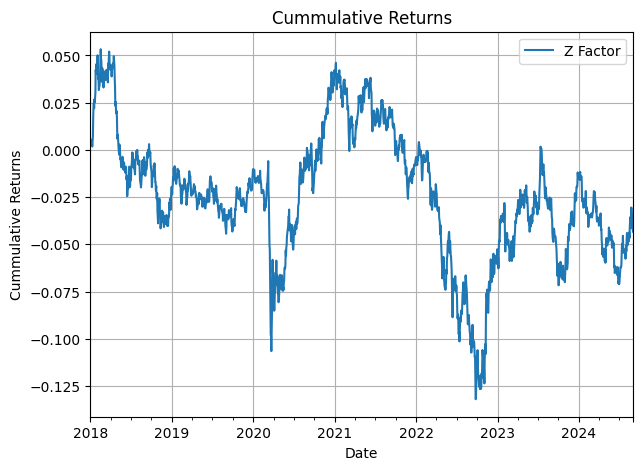

In [71]:
z_factor = pmh.create_portfolio(
    fx_excess_returns, 
    weights=[1 / len(fx_excess_returns.columns) for _ in fx_excess_returns.columns],
    port_name='Z Factor'
)
pmh.calc_cummulative_returns(z_factor)

In [72]:
(
    pmh.calc_iterative_regression(
        fx_excess_returns, z_factor,
        annual_factor=ANNUALIZATION_FACTOR,
        warnings=False,
        keep_columns=['Annualized Alpha', 'Beta', 'R-Squared']
    )
    .loc[:, ['Annualized Alpha', 'Z Factor Beta', 'R-Squared']]
)

,Annualized Alpha,Z Factor Beta,R-Squared
JPY,-0.0522,0.8324,0.3884
EUR,-0.0207,0.9273,0.6951
GBP,0.0006,1.1227,0.6392
MXN,0.0684,1.2498,0.4014
CHF,0.0039,0.8677,0.5931


### 5.

Do your estimates seem in line with a factor pricing model for these trades where $\tilde{r}^z$ is the single factor? 

Explain your conclusion. Don't worry about small sample sizes.

<span style="color:blue">

No, it does not line with a factor pricing model. When using the time-series test of the factor model (which employs the same tool as a LFD), the most important statistics is to have non-significant (or ideally equal to zero) $\alpha$ in the regressions.

JPY, EUR and MXN have considerably high $\alpha$ which serves as evidence that the Z factor alone is not a good pricing model.

</span>

### 6. 

From the performance metrics of these currency trades, 
* Do you expect diversification is particularly useful or not? Be specific.
* Do you expect mean-variance optimization will do relatively well out of sample? Be specific.


<span style="color:blue">

The correlation between the currencies is considerably low (when compared to other classes and especially stocks in the SPY), meaning that we should expect diversification to be fairly important. Furthermore, we should highlight the importance of MXN in this scenario, with a lower average correlation with all other currencies. MXN, differently from the other currencies in the portfolio, is from a developing country, having different idiosyncratic risks when compared to currencies from Europe, Japan, Great Britain, and the US.

Because correlations are low, mean-variance will probably do better out-of-sample than in an environment in which the correlations are high. Lower correlations lead to more stable results of the mean-variance optimization. In such cases, the weights in and out-of-sample are more similar. Still, MV optimization will probably have to deal with its natural instability: it is recommended that the investor also tests performing the optimization with regularization.

On another matter, it is worth to mention that FX trade is often accompanied by high excess kurtosis and very negative skewness, meaning that currencies with high mean returns occasionally suffer big drops in returns. Thus, optimizing only for volatility and mean return leads investors to disconsider those risks associated with the third and fourth moments of the series.

</span>

### 7.

Calculate the tangency weights for a portfolio of these currency trades. 

Report the performance metrics of `2.2` for this tangency portfolio.

<span style="color:blue">

In this scenario, we have a similar result to HW1: the tangency portfolio has negative Sharpe.

This is not an issue, it just relates to: https://canvas.uchicago.edu/courses/58435/discussion_topics/780421

</span>

In [73]:
tang_weights = pmh.calc_tangency_weights(fx_excess_returns)
tang_weights

,Tangency Weights
JPY,2.6725
EUR,4.3039
GBP,-0.6831
MXN,-1.3512
CHF,-3.9421


In [74]:
fx_tangency_portfolio = pmh.create_portfolio(
    fx_excess_returns,
    weights=tang_weights['Tangency Weights'].to_dict(),
    port_name='FX Tangency Portfolio'
)
pmh.calc_summary_statistics(
    fx_tangency_portfolio,
    annual_factor=ANNUALIZATION_FACTOR,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Kurtosis', 'Drawdown'],
    provided_excess_returns=True
)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Excess Kurtosis,Max Drawdown
FX Tangency Portfolio,-0.3385,0.2924,-1.1575,3.8095,-0.9483


<span style="color:blue">

The previously only happen when the GMV has negative excess return, which is the case:

</span>

In [75]:
pmh.calc_summary_statistics(
    pmh.calc_gmv_weights(fx_excess_returns, return_port_ret=True),
    keep_columns=['Mean'],
    annual_factor=ANNUALIZATION_FACTOR,
    provided_excess_returns=True
)

,Mean,Annualized Mean
GMV Portfolio,-0.0001,-0.0138


### 8.

Suppose you are a USD-based investor, but you want to short `1 JPY`, and use it to go long the equivalent amount of USD.

Calculate the excess return to this short-yen (SY) trade, denoted $\tilde{r}_{t+1}^{SY}$.

We're still examining `January 2018` through `August 2024`.

Report the first and last three values of the timeseries of excess returns.

In [76]:
diff_rf = (1 + rf_rates_filtered["USD"]) / (1 + rf_rates_filtered["JPY"]) - 1
usdjpy_fx_rate = 1 / fx_rates_filtered[["JPY"]] # USDJPY rate (buying it means going long on the US dollar)
usdjpy_fx_rate.rename({"JPY": "USDJPY"}, axis=1, inplace=True)
short_jpy = usdjpy_fx_rate.apply(lambda x: x / x.shift() * (1 + diff_rf)).dropna() - 1
short_jpy.rename({"USDJPY": "Short JPY"}, axis=1, inplace=True)
display(short_jpy.dropna().head(3))
display(short_jpy.tail(3))

,Short JPY
date,
2018-01-02,-0.0033
2018-01-03,0.0021
2018-01-04,0.0022


,Short JPY
date,
2024-08-28,0.0045
2024-08-29,0.0030
2024-08-30,0.0084


<span style="color:blue">

The same can be done by using JPY with a minus sign: 

</span>

In [77]:
short_jpy = - fx_excess_returns[['JPY']].rename({'JPY': 'Short JPY'}, axis=1)
display(short_jpy.dropna().head(3))
display(short_jpy.tail(3))

,Short JPY
date,
2018-01-02,-0.0033
2018-01-03,0.0021
2018-01-04,0.0022


,Short JPY
date,
2024-08-28,0.0045
2024-08-29,0.0029
2024-08-30,0.0083


### 9.

Report the performance statistics requested in `2.2` for this short-yen trade. 

Also, what date is the min and max return for this trade?

In [78]:
pmh.calc_summary_statistics(
    short_jpy,
    annual_factor=ANNUALIZATION_FACTOR,
    keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe', 'Kurtosis', 'Drawdown'],
    provided_excess_returns=True,
)

,Annualized Mean,Annualized Vol,Annualized Sharpe,Excess Kurtosis,Max Drawdown
Short JPY,0.0568,0.0847,0.6705,6.5262,-0.1468


,Max Return,Min Return
Short JPY,2020-03-10,2022-12-20


,Max Cumulative Return,Min Cumulative Return
Short JPY,2024-07-10,2018-03-23


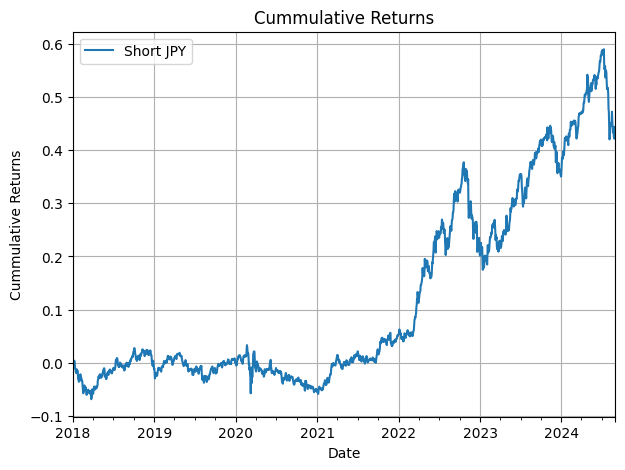

In [79]:
cum_short_jpy = short_jpy.dropna().apply(lambda x: x + 1).cumprod().apply(lambda x: x - 1)

display(
    pd.DataFrame({
        "Max Return": short_jpy.idxmax(),
        "Min Return": short_jpy.idxmin()
    })
)
display(
    pd.DataFrame({
        "Max Cumulative Return": cum_short_jpy.idxmax(),
        "Min Cumulative Return": cum_short_jpy.idxmin()
    })
)

pmh.calc_cummulative_returns(short_jpy)

***